<h1><center> TP1 : Basic functions for Supervised Machine Learning. </center></h1>

The deadline for report submission is Tuesday, November 30th 2021.

Note: the goal of this first TP is to become familiar with 'sklearn' class in Python. In particular, we introduce most popular supervised learning algorithms. 

PART 1 is a list of commands that should be followed step by step. PART 2 is an open problem for which we are waiting for your creativity!

# Imported packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix


%matplotlib notebook

#  PART 1 -- MNIST


In the first part of TP1 we pursue the following goals:
1. Apply standard ML algorithms on a standard benchmark data
2. Learn basic means of data visualizations
3. Get familiar with sklearn's GridSearchCV and Pipeline

# Loading the data

MNIST dataset consists of black and white images of hand-written digits from $0$ to $9$ of size $28 \times 28$.
In this exercise we will work with a small from the original MNIST dataset. 

If you are interested in the whole dataset, execute the following commands
```python
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

Hence, the observations $(X_1, Y_1), \ldots, (X_n, Y_n)$ are such that $X_i \in \mathbb{R}^{784}$ and $Y_i \in \{0, \ldots, 9\}$. To be more precise, each component of vector $X_i$ is a number between $0$ and $255$, which signifies the intensity of black color.

The initial goal is to build a classifier $\hat g$, which receives a new image $X$ and outputs the number that is present on the image.

In [2]:
X_train = np.load('data/data/mnist1_features_train.npy', allow_pickle=True)
y_train = np.load('data/data/mnist1_labels_train.npy', allow_pickle=True)
X_test = np.load('data/data/mnist1_features_test.npy', allow_pickle=True)
y_test = np.load('data/data/mnist1_labels_test.npy', allow_pickle=True)

n_samples, n_features = X_train.shape # extract dimensions of the design matrix
print('Train data contains: {} samples of dimension {}'.format(n_samples, n_features))
print('Test data contains: {} samples'.format(X_test.shape[0]))

Train data contains: 2000 samples of dimension 784
Test data contains: 200 samples


# Looking at the data

Since each observation is actually an image, we can visualize it.

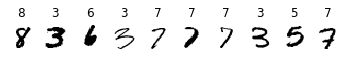

In [3]:
axes = plt.subplots(1, 10)[1]  # creates a grid of 10 plots

# More details about zip() function here https://docs.python.org/3.3/library/functions.html#zip
images_and_labels = list(zip(X_train, y_train)) 
for ax, (image, label) in zip(axes, images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('{}'.format(label))

In [4]:
for i in range(10):
    print('Number of {}s in the train dataset is {}'.format(i, np.sum([y_train == str(i)])))

Number of 0s in the train dataset is 196
Number of 1s in the train dataset is 226
Number of 2s in the train dataset is 214
Number of 3s in the train dataset is 211
Number of 4s in the train dataset is 187
Number of 5s in the train dataset is 179
Number of 6s in the train dataset is 175
Number of 7s in the train dataset is 225
Number of 8s in the train dataset is 186
Number of 9s in the train dataset is 201


From the above we conclude that the dataset is rather balanced, that is, each class contains similar amount of observations. The rarest class is $y = 6$ with $175$ examples and the most common class is $y = 2$ with $226$ examples

# Cross-validation with GridSearchCV

What is the complexity for each of the three following cases? 

When reading the doc, we can see there are various algorithm to compute the nearest neighbors. The default parameter is auto and Sklearn documentation doesn't give a clear explanation what lies behind the auto parameter. We will assume that brute force is used here, which is the method we saw in class. 

*K-NN* 

Let's resume the steps computed for K-NN. 
Assume we fix the number of neighbors K : 
    * We loop over k and for each entry in the samples, compute de the distance d over the n_features and select the smallest distance d (when k=1), the second smallest (when k=2) until the $k^{th}$ smallest (when k=K). The distance computing for an entry is in O(n_features) and this calculations is made n_samples times. So for each neighbor, the complexity is $O$n_{features} * n_{samples})$.
    
As there is K neighbors, the final complexity is $O(K * n_{features} * n_{samples})$.


*SVM*

For the SVM classifier, we use the 1.4.4 section of its Sklearn description. In the case of the linear SVC here, the algorithm used for optimization (coming for the liblinear library) $\textit{scales almost linearly to millions of samples and/or features}$. This means that the algorithm is in $O(n_{features} * n_{samples})$.

*Logistic Regression*

  We can summarize the logistic regression as the optimization of the following parameters : a vectors of bias terms b and the vectors of weights W. This vectors are of dimension $n_{features}$. To optimize this parameters, we compute for each entry the weighted sum : $ \sigma(X_{i}^{T} W) + b$ with $X_{i}$ the vector of features for entry i. For each i in range $n_{features}$, there is $n_{features} calculations.$ Therefore the complexity of logistic regression is $O(n_{features} * n_{samples})$
  
*Grid Search*

The gridsearch only multiply the complexity by the number of fit. For example, we try 5 parameters for the KNN algorithm over 3 CV, so there are 15 fits. This means multiplying the complexity by 15 (a constant) in this and changes nothing. However, we could multiply all the complexities above by $n_{fit}$ to be perfectly rigorous.

In [5]:
# GridSearchCV with kNN : a simple baseline
knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
clf = GridSearchCV(knn, parameters, cv=3)
clf.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy in train is: 0.891497944721333
Classification accuracy on test is: 0.875


**Question:** Explain in your report what happens when we run 
```python
clf.fit(X_train, y_train)
```
<span style="color:##3366FF"> When we run the method .fit, we launch the search over best combinaisons of parameters for our estimator. Here our estimator is a classifier : a  knnclassifier model and our parameters are those we place into the variable "parameters". The data we use for the search are X_train and y_train. A GridSearchCV is an exhaustive search, that means all combinaisons of parameters are tested. Each combinaison of parameters give a new model. For example here we have a model with 1 neighbor, then with 2 neighbors, etc. As we specified cv = 3, we have a 3 fold cross-validation for each tested model.
</span>
<br>
\
**Question:** What is the test accuracy? What would be the accuracy of random guess? 
<br>
<span style="color:##3366FF"> The test accuracy here is the proportion of observations from the X_test dataset that we have rightly classified. <br> The accuracy of a random guess would be 0.1. Explanation : we give randomly a label (number between 0 and 10) to each observation. For each observation we have a probability of 1/10 to have a right guess. </span>
<br>


In [6]:
# SVM Classifier
svc = LinearSVC(max_iter=5000)
parameters2 = {'C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf2 = GridSearchCV(svc, parameters2, cv=3)
clf2.fit(X_train, y_train)


print('Returned hyperparameter: {}'.format(clf2.best_params_))
print('Best classification accuracy in train is: {}'.format(clf2.best_score_))
print('Classification accuracy on test is: {}'.format(clf2.score(X_test, y_test)))

C:\Users\33695\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\33695\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\33695\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Returned hyperparameter: {'C': 0.00390625}
Best classification accuracy in train is: 0.8095074084579332
Classification accuracy on test is: 0.795


C:\Users\33695\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**Question:** What is ``` LinearSVC()``` classifier? Which kernel are we using? What is ```C```? (this is a tricky question, try to find the answer online) 
<br>
<span style="color:##3366FF"> LinearSVC means Linear Support Vector Classification, we use a linear kernel. C is the parameter of regularization, by default there is no specific regularization, C = 1. The strength of the regularization is inversely proportional to C </span>
<br>
\
**Question:** What is the outcome of ```np.logspace(-8, 8, 17, base=2)```? More generally, what is the outcome of ```np.logspace(-a, b, k, base=m)```?

<span style="color:##3366FF"> The outcome of ```np.logspace(-8, 8, 17, base=2)``` is a numpy array of length 17. The numbers of this array are space evenly on a log scale beetween -8 and 8. More generally, np.logspace(-a, b, k, base=m) return numbers spaced evenly on a log scale with -a the starting value, b the stop value, k the number of samples to generate and m the base of the log space

In [11]:
np.logspace(-8, 8, 17, base=2)

array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])

**Question** What is the meaning of the warnings? What is the parameter responsible for its appearence?
<br>
\
<span style="color:##3366FF"> There is a convergence warning, there is not enough iterations to have a convergence. The parameter responsible for its appareance is max_iter

In [7]:
# SVM Classifier + Pipeline
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters3 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf3 = GridSearchCV(pipe, parameters3, cv=3)
clf3.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf3.best_params_))
print('Best classification accuracy in train is: {}'.format(clf3.best_score_))
print('Classification accuracy on test is: {}'.format(clf3.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy in train is: 0.863002432717575
Classification accuracy on test is: 0.84


**Question:** What did we change with respect to the previous run of ```LinearSVC()```?
<span style="color:##3366FF"> With respect to the previous run of LinearSVC(), we add a pipeline. In ML we often have to perform sequence of different transformations (examples : select only some good features, scaling) of raw dataset before applying final estimator. A pipeline enables us to do all these transformations in once. Each transformation is contained in a step. Here we have 2 steps : the 1st step is a scaler which enables us to scale our features (it's a way to normalize our data), the second step is the model svc the define earlier : svc = LinearSVC(max_iter=5000) 
</span>
<br>
\
**Question:** Explain what happens if we execute
```python
    pipe.fit(X_train, y_train)
    pipe.predict(X_test, y_test)
```
<span style="color:##3366FF"> When we run the code we see that there is no warnings concerning convergence anymore so the problem we had earlier was probably due to the absence of normalization. <br>
If we execute the 2 lines of code : we execute the 2 steps of the pipeline (that we explain earlier) on the train set with the method fit. Then our model is trained and we can predict the class of the test dataset. When we apply the pipeline to our test dataset, the first step of scaling is applied to X_test and then the model of the 2nd step.

In [8]:
# Logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters4 = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf4 = GridSearchCV(pipe, parameters4, cv=3)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy in train is: 0.8705039372205788
Classification accuracy on test is: 0.84


**Question:** what is the difference between ```StandardScaler()``` and ```MaxAbsScaler()```? What are other scaling options available in ```sklearn```? 
<br>
\
<span style="color:##3366FF"> It is not the same way of scaling our features. StandardScaler() for a sample x is calculated as: z = (x - u) / s whereas MaxAbsScaler for a sample X = (x1, x2, ..., xn) is calculated as : Z = (x1/m, x2/m, ..., xn/m) with m = max(absolute value(xi)) for i in [1,n]. Other scaling options are RobustScaler (= robust to outlier), MinMaxScaler.
<br>
</span>
\
**Question:** using the previous code as an example achieve test accuracy $\geq 0.9$. You can use any method from sklearn package. Give a mathematical description of the selected method. Explain the range of considered hyperparamers.

In [9]:
# import model
from sklearn.ensemble import RandomForestClassifier

# Random Forest 
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
rf.score(X_test, y_test)
# we have a test accuracy > 0.9 with the parameters by default of the RandomForestClassifier.
# As a consequence we know that the default parameters already give good performances. We can try to consider a range
# of hyperparameters close to the default parameters. 

0.915

In [10]:
rf.get_params().keys() # see the existing parameters of a random forest

# As we don't have a huge dataset we can let the default parameters for max_depth, min_samples_leaf and min_samples_split
# By default we have max_features = sqrt(n_features)

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [80]:
# calculate sqrt(784) to have a interesting range for parameter max_features
from math import sqrt
sqrt(784)

28.0

In [11]:
param_grid_ = {
    'max_features': [25, 28, 35, 50],
    'n_estimators': [90, 100, 150, 200, 300] #number of trees in the forest
}

clf6 = GridSearchCV(estimator = rf, param_grid = param_grid_, cv=3)
clf6.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf6.best_params_))
print('Best classification accuracy in train is: {}'.format(clf6.best_score_))
print('Classification accuracy on test is: {}'.format(clf6.score(X_test, y_test)))

Returned hyperparameter: {'max_features': 28, 'n_estimators': 300}
Best classification accuracy in train is: 0.9115052083567825
Classification accuracy on test is: 0.905


<span style="color:##3366FF"> 
Mathematical explanation for random forest <br>
Random forest= DT(base learner)+ bagging(Row sampling with replacement)+ feature bagging(column sampling) + aggregation(mean/median, majority vote)
    
DT + bagging : decision tree on just a subpart of our sample

feature bagging : to build our decision tree we don't use all our features but just a part of them.

Thanks to bagging on the observations level and on the features level we create trees with little variations. Thus, each tree in our forest is different. Each tree vote for the class of the observation. The majority vote is the predicted class.
</span>

# Visualizing errors

Some ```sklearn``` methods are able to output probabilities ```predict_proba(X_test)```.

**Question** There is a mistake in the following chunk of code. Fix it.

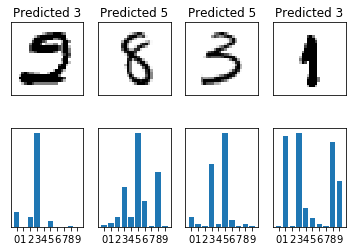

In [12]:
axes = plt.subplots(2, 4)[1]  # creates a grid of 8 plots

# More details about zip() function here https://docs.python.org/3.3/library/functions.html#zip
y_pred = clf4.predict(X_test)
j = 0 # Index which iterates over plots
for true_label, pred_label, image in list(zip(y_test, y_pred, X_test)):
    if j == 4: # We only want to look at 4 first mistakes
        break
    if true_label != pred_label: #if we made a mistake
        # Plotting predicted probabilities
        axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1))[0])
        axes[1, j].set_xticks(np.arange(10)) # add ticks from 0 to 9
        axes[1, j].set_yticks([]) # withdraw yticks 
        
        # Plotting the image
        axes[0, j].imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        axes[0, j].set_xticks([])
        axes[0, j].set_yticks([])
        axes[0, j].set_title('Predicted {}'.format(pred_label))
        j += 1
        

# Changing the Loss function

It often happens that the accuracy is not the right way to evaluate the performance. ```sklearn``` has a large variety of other metrics both in classification and regression. See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

Here we want to understand how to change the cross-validation metric with minimal effort.

In [13]:
# SVM Classifier + Pipeline + New score function

pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters4 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)

clf4 = GridSearchCV(pipe, parameters3, cv=3, scoring=balanced_scorer)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf4.best_score_))
print('Balanced accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best Balanced accuracy in train is: 0.8612334093654231
Balanced accuracy on test is: 0.825627008328415


**Question:** What is ```balanced_accuracy_score```? Write its mathematical description.
<br>
\
<span style="color:##3366FF"> 
The balanced accuracy is a metric to evaluate the performance of our model. It is often use in case of imbalanced datasets in classifications problem. Indeed take for example a binary classification problem where we have a imbalanced dataset with 90% of our observations in class 0 and 10% in class 1. If we take a dummy estimator that always predict the class 0 we'll have an accuracy of 0.9. Thus, in that case, the accuracy score is an inappropriate metric. <br>
Mathematically, the balanced accuracy score is defined as the average of recall obtained on each class. The best value is 1 and the worst value is 0 when adjusted=False (parameter by default). The mathematical formula is given by : <br>
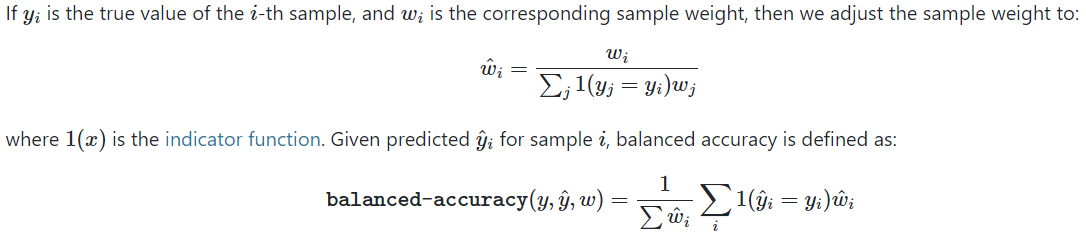
<br>
</span>
\
Sometimes it is important to look at the confusion matrix of the prediction.

**Question:** What is the confusion matrix? What are the conclusions that we can draw from the ```confusion_matrix(y_test, clf4.predict(X_test))```

<span style="color:##3366FF"> 
The confusion matrix is a matrix with each row i corresponding to the true class and with each column j corresponding to the predicted class. Entry i, j in a confusion matrix is the number of observations actually in group i, but predicted to be in group j.
</span>

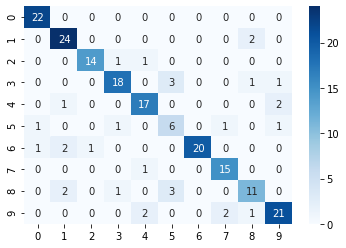

In [14]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, clf4.predict(X_test)), annot=True, cmap='Blues')
#print(confusion_matrix(y_test, clf4.predict(X_test)))

<span style="color:##3366FF"> 
The conclusions we can draw are that the classes where we make most of the mistakes are : <br>
The most common mistake is to predict 5 instead of 8. There are 3 observations that we classified 5 whereas their true label is 8. <br>
The second most common mistakes are to predict 7 instead of 9 and 1 instead of 8. <br>
The class we have the most trouble to rightly predict is 8. In total we predict wrongly 8 6 times.
</span>

# PART 2 -- Problem

The data that we have contains images with $10$ classes. Normally, accuracy is a reasonable choice of the loss function to be optimized, but in this problem we *really* do not like when digits from $\{5, 6, 7, 8, 9\}$ are predicted to be from $\{0, 1, 2, 3, 4\}$.

**Question:** Propose a loss function that would address our needs. Explain your choice.

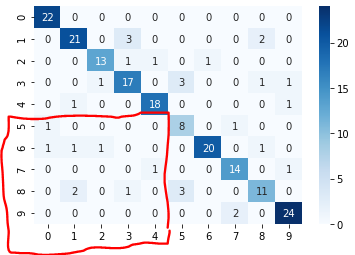

<span style="color:##3366FF">
Let $x_{ij}$ be the coefficient of the $i^{th}$ row and the $j^{th}$ column. <br>
The red area in the confusion matrix represents all the mistakes we *really* want to avoid, that is to say the digits from $\{5, 6, 7, 8, 9\}$ are predicted to be from $\{0, 1, 2, 3, 4\}$. The red area is the ensemble $E_{1}$ = $\{ x_{ij} \text{with i in} \{5,6,7,8,9\} \text{and j in} \{0,1,2,3,4\} \}$  <br>
In the diagonal we have all the observations that we have correctly classified.  <br>
The remaining coefficients that is to say the coefficients in the ensemble $E_{2}$ = $\{ x_{ij} \text{with i in} \{0,1,2,3,4\} \text{and j in} \{5,6,7,8,9\} \text{but i $\neq$ j} \}$  <br>

The idea is that if we sum the coefficients of $E_{1}$ (let call this sum $S_{1}$) we obtain the number of errors we *really* want to avoid. So the worst errors, let call them errors type 1.  <br>
Let call the other type of errors, errors type 2, and the sum the coefficients of $E_{2}$ is noted $S_{2}$.
We want to minimize $S_{1}$ but yet still control for $S_{2}$.
<br>
Thus we have a loss function like this :  <br>
$ l(y, y') =  \alpha S_{1} + \beta S_{2} $ <br>
with $\alpha$ > $\beta$ because errors type 1 are worst than errors type 2
</span>

**Question:** Following above examples, make an ML pipeline that uses *your* loss function and finds appropriate classifiers.

When writing your report on this part, include:
   1. description of your loss function
   2. description of the pipeline
   3. description of the algorithms that you used 

### Description of my loss function

First we are going to define our custom loss function

In [61]:
def my_custom_loss_func(y, y_pred, alpha = 3, beta = 1):
    """ arguments : clf for classifier
                    X for the features
                    y for the true labels
    """
    cm = confusion_matrix(y, y_pred, normalize = 'true') #calculate confusion matrix
    S1 = 0 #initialize S1
    S2 = 0 #initialize S2
    S3 = 0 #initialize S3; S3 is define as the sum of diagonal coefficient
    
    for i in range(5,10): # calculate S1
        for j in range(5): 
            S1 += cm[i,j]
            
    for i in range(10): # calculate S3
        S3 += cm[i,i]
        
    for i in range(10):
        for j in range(10):
            S2 += cm[i,j]
    
    S2 = S2 - S1 - S3
    
    return alpha * S1 + beta * S2

In [62]:
from sklearn.metrics import make_scorer
new_scorer = make_scorer(my_custom_loss_func, greater_is_better = False)

### Description of my pipeline

In [57]:
# GridSearchCV with kNN : a simple baseline
knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
clf = GridSearchCV(knn, parameters, cv=3, scoring = new_scorer)
clf.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification loss in train is: {}'.format(clf.best_score_))
print('Classification loss on test is: {}'.format(clf.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification loss in train is: -3.918515759506081
Classification loss on test is: -4.795053326894757


In [40]:
y_pred = clf.predict(X_test)

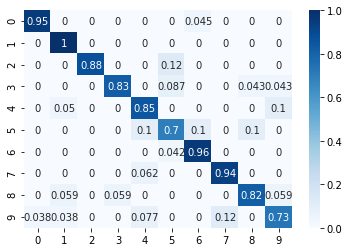

In [58]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize = 'true'), annot=True, cmap='Blues')

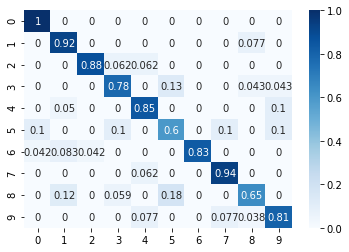

In [51]:
sns.heatmap(confusion_matrix(y_test, clf4.predict(X_test), normalize = 'true'), annot=True, cmap='Blues')

In [63]:
# Logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters4 = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf4 = GridSearchCV(pipe, parameters4, cv=3, scoring = new_scorer)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy in train is: -2.1599561086768033
Classification accuracy on test is: -2.590149354056002


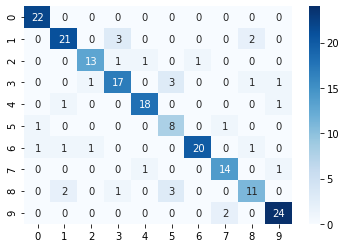

In [65]:
sns.heatmap(confusion_matrix(y_test, clf4.predict(X_test)
                            ), annot=True, cmap='Blues')

### Description of the algorithms 

Describe the different classifiers we use in the pipeline (mathematically speaking) 